In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from IPython.display import clear_output
import seaborn as sns

import cPickle as pk
import pandas as pd
import networkx as nx
import scipy.sparse as sp
import itertools as itls
from itertools import combinations
import numpy as np
from math import sqrt

import sys

## Importing
[to top](#Table-of-Contents) 

In [2]:
pwd

u'/Users/innovation-sfi/Dropbox/Research/Innovation/EPO/Data_processing/Python'

In [3]:
df = pk.load(open('pickles_and_munged_csv/pre1950_cated_cumed_codes_as_ints_v1.pk', 'rb')); df.head()

appln_auth,AT,AU,BE,CA,CH,DE,DK,ES,FI,FR,...,IE,IS,IT,JP,LU,NL,NO,SE,SU,US
pub_year,,,,,,,,,,,,,,,,,,,,,
1836,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[1513, 1789], [1268, 1855], [1762, 1821], [24..."
1837,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[5834, 5836], [4907, 5440], [799, 5648], [602..."
1838,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[1537, 1774], [1154, 1208], [2724, 2748], [40..."
1839,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[4212, 4231], [5078, 6180], [4915, 5001], [33..."
1840,[],[],[],[],[],[],[],[],[],[],...,[],[],[],[],[],[],[],[],[],"[[2722, 2748], [1862, 1862], [1161, 5985], [48..."


In [4]:
s_US = df.US

In [5]:
del df

In [6]:
s_US

pub_year
1836    [[1513, 1789], [1268, 1855], [1762, 1821], [24...
1837    [[5834, 5836], [4907, 5440], [799, 5648], [602...
1838    [[1537, 1774], [1154, 1208], [2724, 2748], [40...
1839    [[4212, 4231], [5078, 6180], [4915, 5001], [33...
1840    [[2722, 2748], [1862, 1862], [1161, 5985], [48...
1841    [[5986, 6001], [3027, 5586], [2964, 3002], [18...
1842    [[4897, 5004], [5740, 5803], [5349, 5421], [11...
1843    [[1762, 1821], [1762, 1821], [5704, 5807], [57...
1844    [[3764, 3825], [1520, 1764], [4641, 4643], [11...
1845    [[5318, 5404], [1060, 4759], [3969, 4052], [23...
1846    [[4097, 6441], [5610, 6516], [1204, 1758], [17...
1847    [[4097, 6441], [1816, 1817], [1722, 5438], [17...
1848    [[335, 2889], [4315, 4750], [5471, 5479, 5479]...
1849    [[5479, 5479], [1496, 1622], [1237, 5473], [50...
1850    [[1754, 1764], [659, 813], [1513, 1789], [1848...
1851    [[327, 332], [4810, 5731], [1829, 1853], [5740...
1852    [[5687, 6199], [4898, 4929], [110, 1211], [489...
1853 

# AdjM building

In [7]:
def make_match_node_AdjDfs(df1, df2):
    
    # assumes dfs are symmetric and square
    # should implement a check here...
    
    # get union of dataframe indexes
    inx_1 = df1.index
    inx_2 = df2.index
    inx_un = inx_1.union(inx_2)
    
    # reindex both index and columns filling with 0
    df1 = df1.reindex(index=inx_un, fill_value=0).reindex(columns=inx_un, fill_value=0)
    df2 = df2.reindex(index=inx_un, fill_value=0).reindex(columns=inx_un, fill_value=0)
    
    return df1, df2

# DeltaCon

In [8]:
def compute_FBP_invs(A):

    # max power to calculate inverse to
    max_pw = 7

    # make identity
    I = sp.identity(A.shape[0])
 
    # remove self links - can't propogate beliefs to self - need to consider if the self links should be counted in
    # degree still?
    A = A - sp.dia_matrix((A.diagonal(), [0]),
                                    shape=(A.shape[0], A.shape[0]))

    # make degree matrix
    ds = [int(x) for x in A.sum(axis=1)]
    D = sp.dia_matrix((ds, [0]),
                     shape=(len(ds), len(ds)))
    
    # compute about-half homophility factor that gaurentees convergences of W power series
    c1 = D.sum() + 2
    c2 = np.dot(D,D).sum() - 1 
    h_h = sqrt((-c1+sqrt(c1**2 + 4*c2))
               /(8*c2)
              )
    
    # compute system constants ah (from ahD) and ch from (achA)
    ah = 4*(h_h**2) /(1-4*(h_h**2))
    ch = 2*h_h / (1-4*(h_h**2))
    
    # create matrix M to form (I - M)^-1
    M = ch*A - ah*D
    
    # expand to power series to compute inverse
    inv = I
    mat = M
    pwr = 1
    while mat.data[mat.data.argmax()] > 10**(-9) and pwr < max_pw:
        inv = inv + mat
        mat = mat * M
        pwr = pwr + 1
    return inv

In [9]:
def DeltaCon(A1, A2):
    
    # quick return for identical networks
    if (A1 != A2).nnz == 0:
        print 'Iden'
        return 1.0
    
    # initialize
    # prior belief for nodes (doesn't really affect results of deltacon says paper)
    # BUT it massively effects the results!!!!!!!
    # the closer to 0.5, the greater the dampening on differences
    p = 0.51
    
    # Solve the linear BP systems (FaBP): inv corresponds to [I + ah*D - ch*A]^-1
    # and multiple by about-half prior beliefs
    inv1 = compute_FBP_invs(A1) * (p-0.5)
    inv2 = compute_FBP_invs(A2) * (p-0.5)
    
    # compute the similarities using Matusita distance
    diffM = (inv1.sqrt() - inv2.sqrt())
    diffM = diffM.multiply(diffM)
    
    # delete diagonal entries -  the influence nodes have on themselves
    diffM = diffM - sp.dia_matrix((diffM.diagonal(), [0]), shape=(diffM.shape[0], diffM.shape[0]))

    return 1 / (1 + sqrt(diffM.sum()))

# Applying

In [10]:
def compute_DeltaCon_US_sims(s_US, years):
    
    # create dataframe to store similarities
    df_temp = pd.DataFrame()
    
    # for countries in dataset
    for i, y1 in enumerate(years):
        print '\n%s' % y1 # to see progress
    
            
        # create adjacency dataframe df1 (via nx.graph) for country1
        g1 = nx.MultiGraph()
        for ls in s_US.loc[y1]:
            g1.add_edges_from(combinations(ls, 2))
        Adf1 = nx.to_pandas_dataframe(g1)

        # for countries 'greater' than country1 in dataset 
        for y2 in years[i:]:

            # if countries are the same then set similarity to 1
            if y1 == y2:
                print 'self',
                df_temp.loc[y1,y2] = 1

            # else if the country of not empty then calculate DeltaCon sim for country1 and country2
            else:
                print y2, # to see progress

                # create adjacency dataframe df2 (via nx.graph) for country2
                g2 = nx.MultiGraph()
                for ls in s_US.loc[y2]:
                    g2.add_edges_from(combinations(ls, 2))    
                Adf2 = nx.to_pandas_dataframe(g2)

                # make adjacency dataframes compatible
                Adf1, Adf2 = make_match_node_AdjDfs(Adf1, Adf2)

                # convert to csr and compute DeltaCon
                sim = DeltaCon(sp.csr_matrix(Adf1.values), sp.csr_matrix(Adf2.values))

                #assign to dataframe
                df_temp.loc[y1,y2] = sim
                df_temp.loc[y2,y1] = sim
                    
    return df_temp

In [11]:
# initialise 
years = range(1836,1901)
USdf = compute_DeltaCon_US_sims(s_US, years)


1836
1836
self 1837
1837 0.799226937272
1838
1838 0.752663442651
1839
1839 0.734541894989
1840
1840 0.714358946496
1841
1841 0.692078592798
1842
1842 0.678956456491
1843
1843 0.66565038991
1844
1844 0.65455918939
1845
1845 0.646066684857
1846
1846 0.63915937691
1847
1847 0.634231882057
1848
1848 0.627340018019
1849
1849 0.620954886483
1850
1850 0.613936992472
1851
1851 0.607635747906
1852
1852 0.602338702062
1853
1853 0.597272564687
1854
1854 0.587956798032
1855
1855 0.577021009395
1856
1856 0.567298432574
1857
1857 0.55854789942
1858
1858 0.548499758949
1859
1859 0.536758553779
1860
1860 0.526167491753
1861
1861 0.521095198512
1862
1862 0.515083269876
1863
1863 0.505772000507
1864
1864 0.496321907806
1865
1865 0.489828023203
1866
1866 0.479379747191
1867
1867 0.465332349496
1868
1868 0.453536347518
1869
1869 0.442053181703
1870
1870 0.43282931953
1871
1871 0.424141614872
1872
1872 0.415246289629
1873
1873 0.408688264161
1874
1874 0.402670203483
1875
1875 0.396689354767
1876
1876 0.38

In [14]:
pk.dump(USdf, open('pickles_and_munged_csv/sim_dfs/all_grant_no_priors_pre1950_deltacon_union_sim_US_1836_1900.pk',
                            'wb'))

In [12]:
USdf

,1836,1837,1838,1839,1840,1841,1842,1843,1844,1845,...,1891,1892,1893,1894,1895,1896,1897,1898,1899,1900
1836,1.000000,0.799227,0.752663,0.734542,0.714359,0.692079,0.678956,0.665650,0.654559,0.646067,...,0.309080,0.305443,0.301166,0.297347,0.294053,0.290786,0.287727,0.284521,0.281801,0.279365
1837,0.799227,1.000000,0.806505,0.771802,0.740582,0.710298,0.693699,0.678578,0.667521,0.658970,...,0.310087,0.306391,0.302083,0.298216,0.294890,0.291604,0.288522,0.285289,0.282550,0.280090
1838,0.752663,0.806505,1.000000,0.843796,0.787119,0.740248,0.718831,0.700056,0.685556,0.675470,...,0.311207,0.307486,0.303129,0.299224,0.295873,0.292553,0.289461,0.286218,0.283459,0.280976
1839,0.734542,0.771802,0.843796,1.000000,0.833380,0.765630,0.739487,0.717621,0.702203,0.691693,...,0.311862,0.308109,0.303714,0.299799,0.296426,0.293085,0.289973,0.286706,0.283938,0.281441
1840,0.714359,0.740582,0.787119,0.833380,1.000000,0.808096,0.774108,0.744748,0.724347,0.711844,...,0.312660,0.308877,0.304449,0.300511,0.297108,0.293741,0.290605,0.287319,0.284539,0.282020
1841,0.692079,0.710298,0.740248,0.765630,0.808096,1.000000,0.852860,0.799887,0.765330,0.747032,...,0.313016,0.309211,0.304761,0.300806,0.297397,0.294021,0.290873,0.287570,0.284782,0.282254
1842,0.678956,0.693699,0.718831,0.739487,0.774108,0.852860,1.000000,0.855002,0.807305,0.783620,...,0.314385,0.310526,0.306023,0.302011,0.298554,0.295144,0.291962,0.288619,0.285797,0.283240
1843,0.665650,0.678578,0.700056,0.717621,0.744748,0.799887,0.855002,1.000000,0.858781,0.824963,...,0.316067,0.312154,0.307581,0.303526,0.300024,0.296580,0.293358,0.289970,0.287114,0.284516
1844,0.654559,0.667521,0.685556,0.702203,0.724347,0.765330,0.807305,0.858781,1.000000,0.884618,...,0.317638,0.313665,0.309021,0.304905,0.301346,0.297858,0.294595,0.291162,0.288266,0.285633
1845,0.646067,0.658970,0.675470,0.691693,0.711844,0.747032,0.783620,0.824963,0.884618,1.000000,...,0.318182,0.314177,0.309501,0.305360,0.301788,0.298282,0.295003,0.291555,0.288645,0.286001


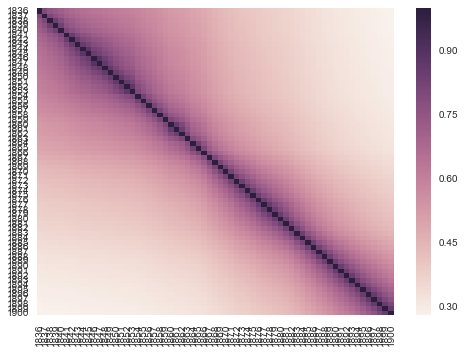

In [13]:
sns.heatmap(USdf)